Google Colab Setup
---

Make sure to select GPU in Runtime > Change runtime type > Hardware accelerator

In [ ]:
#@title << Setup Google Colab by running this cell {display-mode: "form"}
import sys
if 'google.colab' in sys.modules:
    # Clone GitHub repository
    !git clone --single-branch --branch evaluation_setup https://github.com/pacm/rl-workshop.git
        
    # Copy files required to run the code
    !cp -r "rl-workshop/agents" "rl-workshop/env" "rl-workshop/rl_helpers" .
    
    # Install packages via pip
    !pip install -r "rl-workshop/colab-requirements.txt"
    
    # Restart Runtime
    import os
    os.kill(os.getpid(), 9)

PER and curiosity
---

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import os
import datetime
from agents.dqn import DQNAgent, ConvQNetworkFactory
from agents.random import RandomAgent
from agents.logging import TensorBoardLogger, NoLogger
from agents.curiosity import CuriosityDQNAgent
from env.env import WindowedGridView, DeliveryDrones

from rl_helpers.rl_helpers import MultiAgentTrainer, test_agents, plot_cumulative_rewards, plot_rolling_rewards

In [10]:
env = WindowedGridView(DeliveryDrones(), radius=3)
env.env_params.update({'n_drones': 11, 'pickup_reward': 0, 'discharge': 1, 'rgb_render_rescale': 2.0})

In [11]:
""" load tensorboard extension (colab only)"""
%load_ext tensorboard

The tensorboard module is not an IPython extension.


In [ ]:
""" startup tensorboad (colab only)"""
%tensorboard --logdir logs

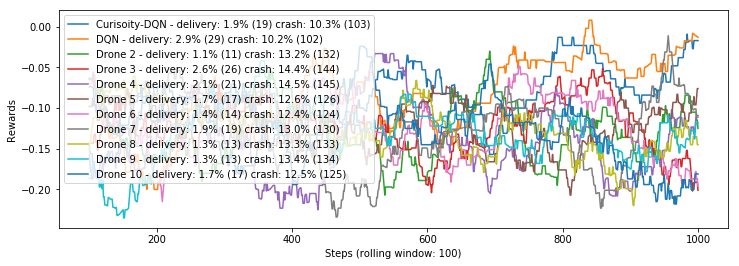

In [13]:
"""DQN with intrinsic curiosity module"""
dqn_factory = ConvQNetworkFactory(env, conv_layers=[
        {'out_channels': 32, 'kernel_size': 3, 'stride': 2, 'padding': 1},
        {'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1},
        {'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1},
        {'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1},
    ], dense_layers=[256])

curiosity_logger = TensorBoardLogger(os.path.join('logs', 'curiosity'), datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
dqn_logger = TensorBoardLogger(os.path.join('logs', 'dqn'), datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
# curisoiry_logger = NoLogger()
# dqn_logger = NoLogger()

curiosity_agent = CuriosityDQNAgent(env, dqn_factory, gamma=0.95, epsilon_start=1, epsilon_decay=0.99,
                                    epsilon_end=0.01, memory_size=10000, batch_size=64,
                                    target_update_interval=500, 
                                    eta=0.01,
                                    beta=0.2,
                                    lmbda=0.1,
                                    icm_embed_convs=[(32, 3, 2, 1), (32, 3, 1, 1), (32, 3, 1, 1), (32, 3, 1, 1)],
                                    icm_forward_hidden=[256],
                                    icm_inverse_hidden=[256],
                                    logger=curiosity_logger)

dqn_agent = DQNAgent(env, dqn_factory, gamma=0.95, epsilon_start=1, epsilon_decay=0.99, epsilon_end=0.01, 
                     memory_size=10000, batch_size=64, target_update_interval=500, logger=dqn_logger)

# Reset environment
env.reset()

# Setup random opponents
agents = {drone.index: RandomAgent(env) for drone in env.drones}
agents[0] = curiosity_agent
agents[1] = dqn_agent

# Create trainer
trainer = MultiAgentTrainer(env, agents, reset_agents=True, seed=0)

trainer.train(1000)
plot_rolling_rewards(trainer.rewards_log, drones_labels={0: 'Curisoity-DQN', 1: 'DQN'})

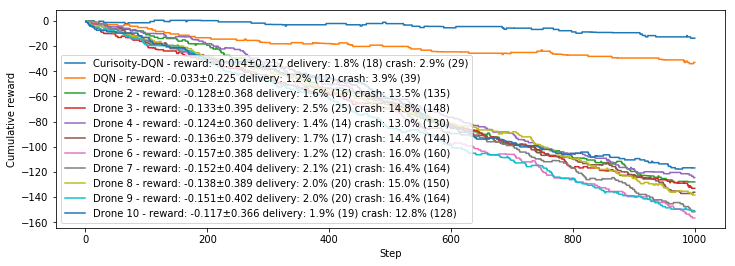

In [14]:
rewards_log = test_agents(env, agents, n_steps=1000, seed=1234)
plot_cumulative_rewards(rewards_log, drones_labels={0: 'Curisoity-DQN', 1: 'DQN'})

In [15]:
import os
path = os.path.join('videos', 'curisoity.mp4')
render_video(env, agents, path, n_steps=60, fps=1, seed=None)

NameError: name 'render_video' is not defined

In [16]:
import os

curiosity_agent.save(os.path.join('agents', 'curiosity_agent.pt'))